In [24]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import itertools
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import gensim

2022-05-13 02:24:45.447040: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-13 02:24:45.447086: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD

In [2]:
# Construindo bag-of-words com count-vectorizer 
count_vectorizer = CountVectorizer() 

In [3]:
clean_texts = pd.read_csv('clean_data.csv')


In [4]:
# Separando o texto da variável alvo 
list_corpus = clean_texts["text"].tolist() 
list_labels = clean_texts["class_label"].tolist() 

In [5]:
# Construindo exemplos para treinamento e teste 
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40) 

In [6]:
# Aprendendo o vacabulário e contabilizando os termos para teste 
X_train_counts = count_vectorizer.fit_transform(X_train) 

In [7]:
# Contabilizando os termos no vocabulário aprendido para treino 
X_test_counts = count_vectorizer.transform(X_test)

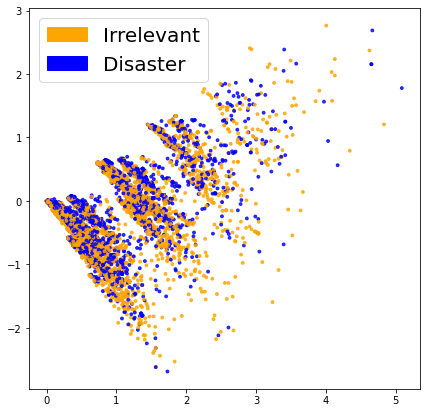

In [13]:
# Método para plotar o gráfico com a distribuição do vocabulário por variável alvo 
def plot_LSA(test_data, test_label, savepath="PCA_demo.csv",plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.fit_transform(test_data)
    color_mapper = {label:idx for idx,label in enumerate(set(test_label))}
    color_column = [color_mapper[label] for label in test_label]
    colors = ['orange','blue','blue']
    if plot:
        
        plt.scatter(lsa_scores[:,0],lsa_scores[:,1],s=8,alpha=0.8,c=test_label,cmap=matplotlib.colors.ListedColormap(colors))
        red_patch = mpatches.Patch(color='orange', label='Irrelevant')
        blue_patch = mpatches.Patch(color='blue', label='Disaster')
        plt.legend(handles=[red_patch,blue_patch],prop={'size':20})
        

plt.figure(figsize=(7,7))
plot_LSA(X_train_counts,y_train)
plt.show()

### Treinando o Classificador

In [14]:
from sklearn.linear_model import LogisticRegression


In [15]:
# Aplicando configurações no modelo 
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',multi_class='multinomial', n_jobs=-1, random_state=40) 
#Treinando o modelo com o vocabulário construindo e as variáveis alvo 
clf.fit(X_train_counts, y_train) 
#Realizando as predições para o conjunto de teste 
y_predicted_counts = clf.predict(X_test_counts)

### Avaliando o Classificador



In [22]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import confusion_matrix


In [19]:
# Método para extração das métricas de avaliação usando a parte dos dados que separamos para teste. 
def get_metrics(y_test, y_predicted):      
   # true positives / (true positives+false positives)    
   precision = precision_score(y_test, y_predicted, pos_label=None,average='weighted')                 
   # true positives / (true positives + false negatives)    
   recall = recall_score(y_test, y_predicted, pos_label=None,average='weighted')        
   # harmonic mean of precision and recall    
   f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')        
   # true positives + true negatives/ total    
   accuracy = accuracy_score(y_test, y_predicted)    
   return accuracy, precision, recall, f1 
accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts) 
print("accuracy = {%.3f}, precision = {%.3f}, recall = %.3f, f1 = {%.3f}" % (accuracy, precision, recall, f1))


accuracy = {0.754}, precision = {0.752}, recall = 0.754, f1 = {0.753}


In [38]:
#Método para plotar a matriz de confusão. 
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=25)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=3)
    plt.xlabel('Predicted label', fontsize=3)

    return plt

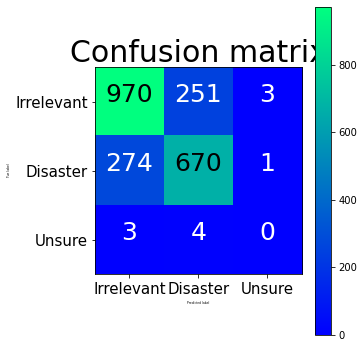

Count Vectorizer confusion matrix
[[970 251   3]
 [274 670   1]
 [  3   4   0]]


In [39]:
cm = confusion_matrix(y_test, y_predicted_counts) 
fig = plt.figure(figsize=(5, 5)) 
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix') 
plt.show() 
print("Count Vectorizer confusion matrix") 
print(cm)

In [40]:
# Método para identificação das features mais importantes na tomada de decisão. 
def get_most_important_features(vectorizer, model, n=5):    
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}        
    # loop for each class    
    classes ={}    
    for class_index in range(model.coef_.shape[0]):        
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]        
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)        
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])        
        bottom = sorted_coeff[-n:]        
        classes[class_index] = {'tops':tops,'bottom':bottom}    
    return classes 
importance = get_most_important_features(count_vectorizer, clf, 10)

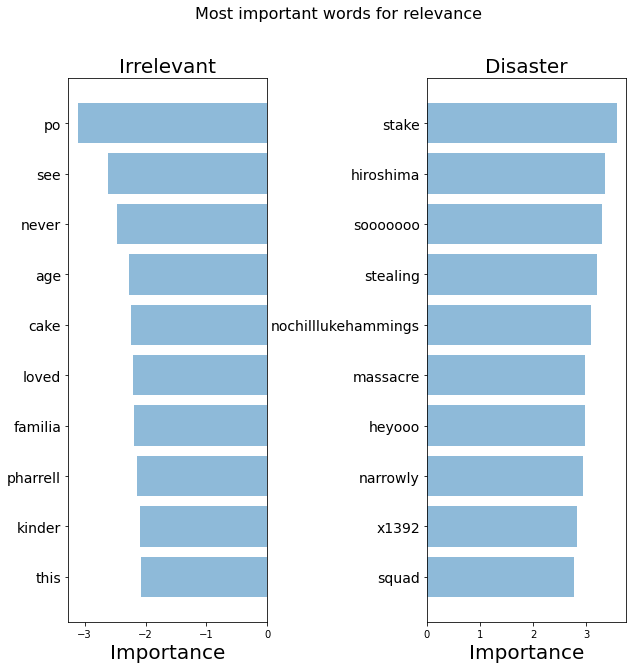

In [41]:
# Método para plotar as featrues mais importantes para cada variável alvo. 
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):    
    y_pos = np.arange(len(top_words))    
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]    
    top_pairs = sorted(top_pairs, key=lambda x: x[1])        
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]    
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)        
    top_words = [a[0] for a in top_pairs]    
    top_scores = [a[1] for a in top_pairs]        
    bottom_words = [a[0] for a in bottom_pairs]    
    bottom_scores = [a[1] for a in bottom_pairs]        
    fig = plt.figure(figsize=(10, 10))      
    plt.subplot(121)    
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)    
    plt.title('Irrelevant', fontsize=20)    
    plt.yticks(y_pos, bottom_words, fontsize=14)    
    plt.suptitle('Key words', fontsize=16)    
    plt.xlabel('Importance', fontsize=20)        
    plt.subplot(122)    
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)    
    plt.title('Disaster', fontsize=20)    
    plt.yticks(y_pos, top_words, fontsize=14)    
    plt.suptitle(name, fontsize=16)    
    plt.xlabel('Importance', fontsize=20)        
    plt.subplots_adjust(wspace=0.8)    
    plt.show() 
top_scores = [a[0] for a in importance[1]['tops']] 
top_words = [a[1] for a in importance[1]['tops']] 
bottom_scores = [a[0] for a in importance[1]['bottom']] 
bottom_words = [a[1] for a in importance[1]['bottom']] 
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

### TF-IDF Bag of Words

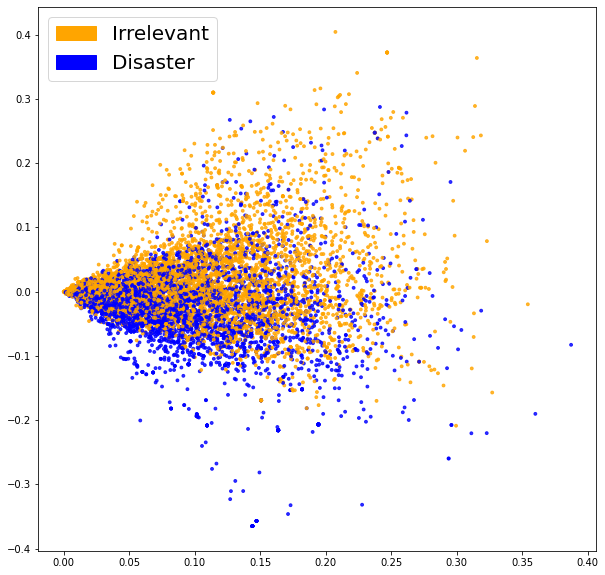

In [42]:
# Construindo bag-of-words com count-vectorizer 
tfidf_vectorizer = TfidfVectorizer() 
# Aprendendo o vacabulário e contabilizando os termos para teste 
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train) 
# Contabilizando os termos no vocabulário aprendido para treino 
X_test_tfidf = tfidf_vectorizer.transform(X_test) 
# Plotando a distribuição do vocabulário 
fig = plt.figure(figsize=(10, 10))          
plot_LSA(X_train_tfidf, y_train) 
plt.show()

In [43]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',                          multi_class='multinomial', n_jobs=-1, random_state=40) 
#Treinando o modelo com o vocabulário construindo e as variáveis alvo 
clf_tfidf.fit(X_train_tfidf, y_train) 
y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [44]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf) 
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf,recall_tfidf, f1_tfidf))

accuracy = 0.762, precision = 0.760, recall = 0.762, f1 = 0.761


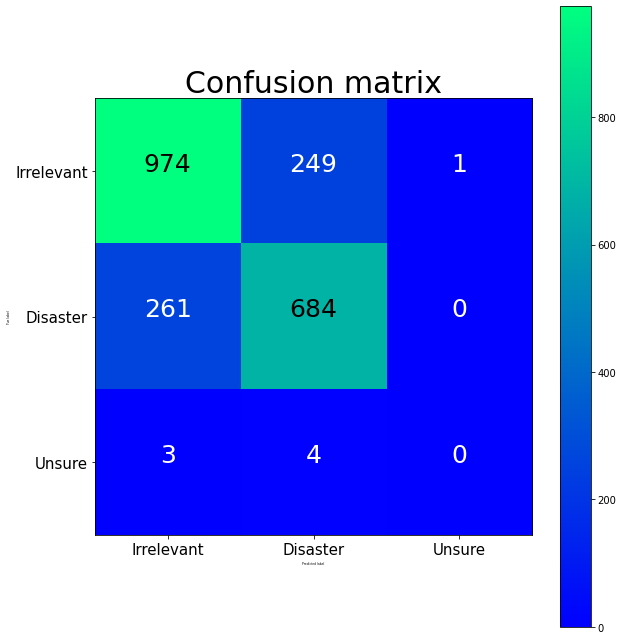

TFIDF confusion matrix
[[974 249   1]
 [261 684   0]
 [  3   4   0]]
BoW confusion matrix
[[970 251   3]
 [274 670   1]
 [  3   4   0]]


In [46]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf) 
fig = plt.figure(figsize=(9, 9)) 
plot = plot_confusion_matrix(cm2, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix') 
plt.show() 
print("TFIDF confusion matrix") 
print(cm2) 
print("BoW confusion matrix") 
print(cm)

In [47]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

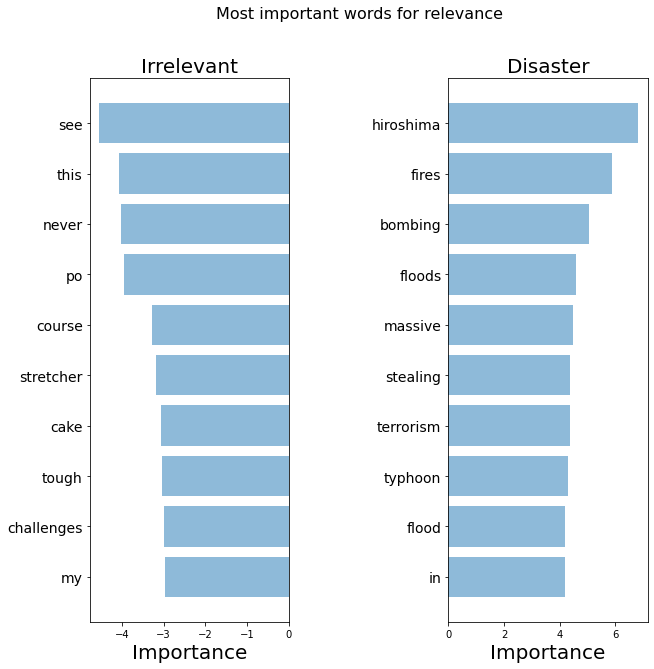

In [48]:
top_scores = [a[0] for a in importance_tfidf[1]['tops']] 
top_words = [a[1] for a in importance_tfidf[1]['tops']] 
bottom_scores = [a[0] for a in importance_tfidf[1]['bottom']] 
bottom_words = [a[1] for a in importance_tfidf[1]['bottom']] 
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [ ]:
#Treinando a matriz de relação com notícias do Google 
#O conjunto de dados para treinar a matriz pode ser acessado em: #https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit 
word2vec_path = "GoogleNews-vectors-negative300.bin.gz" 
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):    
    if len(tokens_list)<1:        
       return np.zeros(k)    
    if generate_missing:        
       vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]    
    else:        
       vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]    
    length = len(vectorized)    
    summed = np.sum(vectorized, axis=0)    
    averaged = np.divide(summed, length)    
    return averaged 


In [ ]:
#Montagem do arquivo de treinamento contento a relação semântica entre as palavras 
def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):    
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors,generate_missing=generate_missing))    
    return list(embeddings)

In [ ]:
embeddings = get_word2vec_embeddings(word2vec, clean_texts) 
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels,test_size=0.2, random_state=40) 
fig = plt.figure(figsize=(10, 10))          
plot_LSA(embeddings, list_labels) 
plt.show()

In [ ]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',multi_class='multinomial', random_state=40) 
clf_w2v.fit(X_train_word2vec, y_train_word2vec) 
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [ ]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec) 
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec,recall_word2vec, f1_word2vec))

In [ ]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec) 
fig = plt.figure(figsize=(9, 9)) 
plot = plot_confusion_matrix(cm_w2v, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show() 
print("Word2Vec confusion matrix") 
print(cm_w2v) 
print("TFIDF confusion matrix") 
print(cm2) 
print("BoW confusion matrix") 
print(cm)